In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

# Theory

Bond price with constant interest rate:
$$
dB_t = rB_tdt
$$

and a stock price that evolves according to one of the later specified models.

$$
X_T = X_0 + \int_0^T X-t[\alpha_t(\mu - r) + r]dt + \int_0^T X_t \alpha_t \sigma dW_t
$$

Then the non-negative wealth Process $X$ controlled by the proportion $(\alpha_t)_{t\ge 0}$ with values in $\mathbb{R}$, invested in the stock is goverened by the following diffusion:
$$
dX_t = \alpha_t X_t \frac{dS_t}{S_t} + (1-\alpha_t)X_trdt, X_0 = x
$$

The goal is to maximize over the portfolio strategy $(\alpha_t)$ the expected utility at terminal time T:
$$
\max_{\alpha}\mathbb{E}_P[u(X_T)]
$$

We then parameterize the strategy $\alpha$ as a neural network:
$$
\alpha_t = g(I_t, t)
$$

# Parameters

In [2]:
N = 30 # time discretization
S0 = 1 # intital value of Stock
X0 = 1 # initial wealth
T = 1 # maturity
sigma = 0.2 # volatility
mu = 0.1 # drift
r = 0.02 # riskless rate
gamma = 0.0
R = 10**5 # number of trajectories
m = 1 # dimension of price

# Scenario Generator

### Sample Generation

In [3]:
# seed to reproduce
np.random.seed(42)

In [4]:
samples_Z_1 = np.random.normal(loc=0, scale=1, size=(m, N+1,R))

#### BS Model

We have the equation $dS_t = \mu S_t dt + \sigma S_t dW_t$ to model the stock prices.

We discretize this and get:
$S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t$

Where $Z_t \sim \mathcal{N}(0, 1)$ 

In [5]:
BS_price_paths = np.zeros((m, N+1, R))
BS_price_paths[0, 0, :] = S0 

In [6]:
for i in range(R):
    S_t = S0
    for j in range(N):
        sample = samples_Z_1[0, j, i]
        S_t += mu * S_t * T/N + sigma * S_t * np.sqrt(T/N) * sample
        BS_price_paths[0, j+1, i] = S_t

In [7]:
print(BS_price_paths[0, 30, :].mean())
print(BS_price_paths[0, 30, :].std())

1.104327682154651
0.22233370197978133


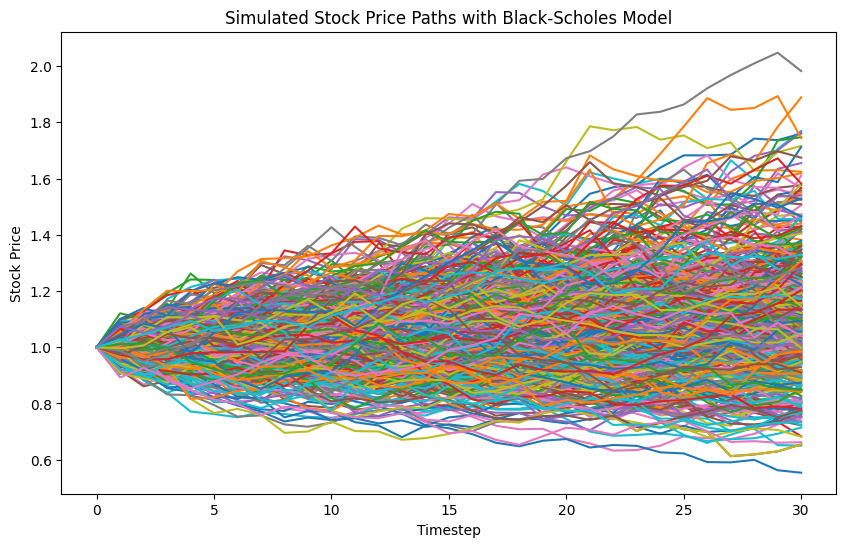

In [8]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(R, 500)
for i in paths:
    plt.plot(BS_price_paths[0, :,i])# , label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with Black-Scholes Model')
# plt.legend()
plt.show()

### CEV Model

For this model we have this descretisation looks like this $S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S^{\gamma}_t \sqrt{\Delta t}Z_T$

This is very similar to the BS model. The major difference is that we have a $\gamma$ parameter that puts the volatility and the price into relationship. Meaning here the Volatility of the stock depends on the Price of the Stock.

Some typical values are:

$\gamma \lt 1$: volatility increases when prices fall. This typically can be seen in equity markets

$\gamma \gt 1$: Volatility increases when prices rise. This can be seen for example in the commodity markets.

$\gamma = 1$: the then results in geometric Brownian Motion and then the CEV model is just the standard BS Model

In [9]:
# specify additional Parameters
gamma_cev = 0.8

CEV_price_paths = np.zeros((m, N+1, R))
CEV_price_paths[0, 0, :] = S0

In [10]:
for i in range(R):
    S_t = S0
    for j in range(N):
        sample = samples_Z_1[0, j, i]
        S_t += mu * S_t * T/N + sigma * S_t**gamma * np.sqrt(T/N) * sample
        CEV_price_paths[0, j+1, i] = S_t

In [11]:
print(CEV_price_paths[0, 30, :].mean())
print(CEV_price_paths[0, 30, :].std())

1.104334656623578
0.21018628841936812


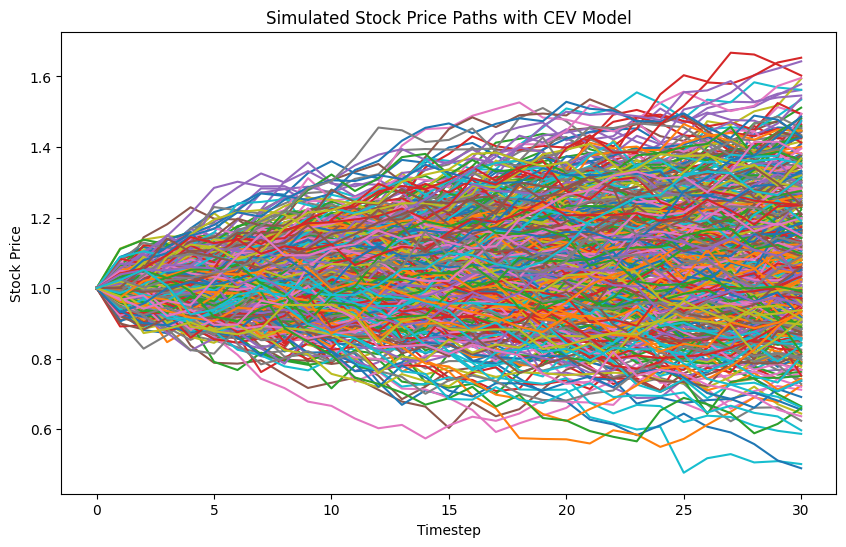

In [12]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(R, 500)
for i in paths:
    plt.plot(CEV_price_paths[0, :,i])# , label=f'Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths with CEV Model')
# plt.legend()
plt.show()

### Heston Model

Now we have the following discretization.

Volatility Process:
$$
\nu_{t + \Delta t} = \nu_t + \kappa(\theta - \nu_t)\Delta t + \xi \sqrt{\nu_t}\sqrt{\Delta t}Z^2_t
$$

Stock Price Process:
$$
S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sqrt{\nu_t}S_t\sqrt{\Delta t}Z^1_t
$$

Correlated Random Variables:
$$
Z^2_t = \rho Z^1_t + \sqrt{1-\rho^2}Z^3_t
$$
where $Z^1_t, Z^3_t \sim \mathcal{N}(0,1)$

In [13]:
# additional parameters and samples
samples_Z_3 = np.random.normal(loc=0, scale=1, size=(m, N+1,R))

xi = 0.35
nu_0 = 0.025
theta = 0.04
kappa = 3
rho = -0.7

In [14]:
samples_Z_2 = rho*samples_Z_1 + np.sqrt(1-rho**2)*samples_Z_3

In [15]:
heston_price_paths = np.zeros((m, N+1, R))
heston_vol_paths = np.zeros((m, N+1, R))

heston_price_paths[:,0] = S0
heston_vol_paths[:,0] = nu_0

In [16]:
for i in range(R):
    nu_t = nu_0
    S_t = S0
    for j in range(N):
        sample_Z_2 = samples_Z_2[0, j, i]
        sample_Z_1 = samples_Z_1[0, j, i]

        # Variance update 
        new_nu = nu_t + kappa * (theta - nu_t) * T/N + xi * np.sqrt(np.maximum(nu_t, 0)) * np.sqrt(T/N) * sample_Z_2
        new_nu = np.maximum(new_nu, 0)  # Ensure non-negativity

        S_t += mu * S_t * T/N + np.sqrt(nu_t) * S_t * np.sqrt(T/N) * sample_Z_1

        heston_price_paths[0, j+1, i] = S_t
        heston_vol_paths[0, j+1, i] = new_nu

        nu_t = new_nu


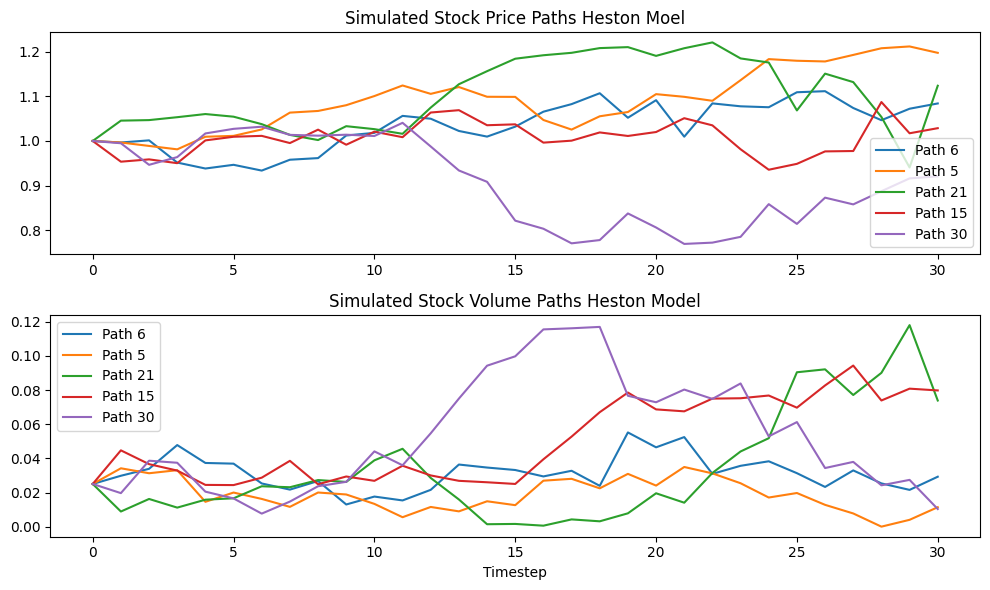

In [17]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(N, 5)
plt.subplot(2, 1, 1)
for i in paths:
    plt.plot(heston_price_paths[0, :,i], label=f'Path {i+1}')
plt.title('Simulated Stock Price Paths Heston Moel')
plt.legend()

plt.subplot(2, 1, 2)
for i in paths:
    plt.plot(heston_vol_paths[0, :,i] , label=f'Path {i+1}')
plt.title('Simulated Stock Volume Paths Heston Model')
plt.xlabel('Timestep')
plt.legend()

plt.tight_layout()
plt.show()

For the Heston Model we have the risk of having negativ $\nu_{t + \Delta t}$ values which would mean negative variance and would then be used in the np.sqrt function. This does not make sense. currently i clip the variance just at 0 but there are other possibilities to resolve this. Maybe look into this.

### Comparison of Paths

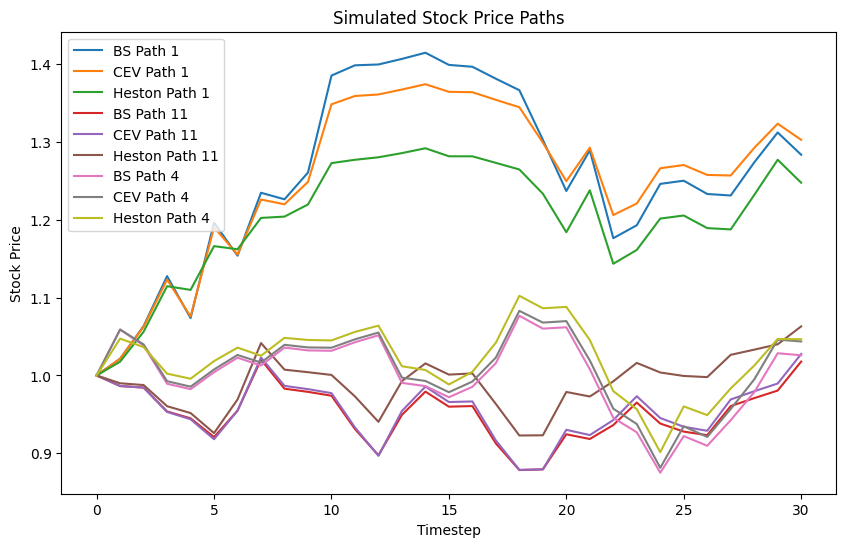

In [18]:
plt.figure(figsize=(10, 6))
paths = np.random.choice(N, 3)
for i in paths:
    plt.plot(BS_price_paths[0, :,i], label=f'BS Path {i+1}')
    plt.plot(CEV_price_paths[0, :,i], label=f'CEV Path {i+1}')
    plt.plot(heston_price_paths[0, :,i], label=f'Heston Path {i+1}')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths')
plt.legend()
plt.show()

# Merton Approach

The calculated Merton-Optimalstrategy is
$$
\alpha^{*} = \frac{\mu - r}{\sigma^2(1 - \gamma)}.
$$
So it it a constant dependent on the drift term, the volatility, the riskless rate and the risk aversion of the investor.

The Problem with this formula is that the drift in the Markets is very hard to approximate.

In [19]:
def merton_wealth(price_paths, initial_wealth, gamma, dim=(N,R)):
    logX = np.zeros((dim[0]+1, dim[1]))
    logX[0,] = np.log(initial_wealth)*np.ones((1,dim[1]))
    alphastar = (mu - r)/(sigma**2*(1-gamma))
    for i in range(dim[1]):
        for j in range(dim[0]):
            logreturns = np.log(price_paths[0, j+1, i]) - np.log(price_paths[0,j,i])
            logX[j+1, i] = logX[j,i] + alphastar*logreturns + (1-alphastar)*r*T/dim[0] - alphastar**2*sigma**2*T/(2*dim[0])
            # increment = np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N))
            # logX[j+1,i] =logX[j,i]+increment*alphastar+r*T/N*(1-alphastar)-alphastar**2*sigma**2*T/(2*N)

    X = np.exp(logX)
    if gamma == 0.0:
        util = np.log(X[dim[0],:])
    else:
        util = (X[dim[0],:] ** (gamma)-1) / gamma
    loss = -np.mean(util)
    expected_wealth = X[dim[0], :].mean()
    std_wealth = X[dim[0], :].std()
    return alphastar, expected_wealth, std_wealth, loss, X

In [20]:
# BS Prices
alphastar, expected_wealth, std_wealth, loss, Merton_X = merton_wealth(BS_price_paths, 1.0, gamma)
print('Merton results to Black-Scholes Prices')
print('---------------------------------------')
print(f'Optimal Merton Strategy: {alphastar}')
print(f'Expected Wealth with Merton Strategy: {expected_wealth}')
print(f'Standard Deviation Final Wealth with Merton Strategy: {std_wealth}')
print(f'Utility Loss with Merton Strategy: {loss}')

Merton results to Black-Scholes Prices
---------------------------------------
Optimal Merton Strategy: 1.9999999999999996
Expected Wealth with Merton Strategy: 1.14821326172667
Standard Deviation Final Wealth with Merton Strategy: 0.4754231757525837
Utility Loss with Merton Strategy: -0.05861224636472868


In [21]:
# CEV Prices
alphastar, expected_wealth, std_wealth, loss, Merton_X = merton_wealth(CEV_price_paths, 1.0, gamma)
print('Merton results to CEV Prices')
print('---------------------------------------')
print(f'Optimal Merton Strategy: {alphastar}')
print(f'Expected Wealth with Merton Strategy: {expected_wealth}')
print(f'Standard Deviation Final Wealth with Merton Strategy: {std_wealth}')
print(f'Utility Loss with Merton Strategy: {loss}')

Merton results to CEV Prices
---------------------------------------
Optimal Merton Strategy: 1.9999999999999996
Expected Wealth with Merton Strategy: 1.143473184998273
Standard Deviation Final Wealth with Merton Strategy: 0.42365148458492213
Utility Loss with Merton Strategy: -0.05998332765943566


In [22]:
# Heston Prices
alphastar, expected_wealth, std_wealth, loss, Merton_X = merton_wealth(heston_price_paths, 1.0, gamma)
print('Merton results to Heston Prices')
print('---------------------------------------')
print(f'Optimal Merton Strategy: {alphastar}')
print(f'Expected Wealth with Merton Strategy: {expected_wealth}')
print(f'Standard Deviation Final Wealth with Merton Strategy: {std_wealth}')
print(f'Utility Loss with Merton Strategy: {loss}')

Merton results to Heston Prices
---------------------------------------
Optimal Merton Strategy: 1.9999999999999996
Expected Wealth with Merton Strategy: 1.1399183757939861
Standard Deviation Final Wealth with Merton Strategy: 0.39237074318103093
Utility Loss with Merton Strategy: -0.06378450217074573


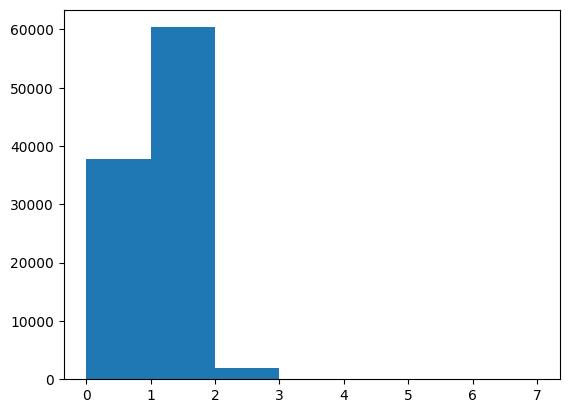

In [23]:
bins = np.arange(0, 8, 1)
plt.hist(Merton_X[N,:], bins=bins)
plt.show()

# Markovian Approach

### Network

In [24]:
# additional Parameters
d = 3 # number of layers
n = 32 # hidden dimension

In [25]:
class StrategyBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(StrategyBlock, self).__init__()

        self.layers = nn.ModuleList()

        first_layer = nn.Linear(input_dim, hidden_dim)
        nn.init.normal_(first_layer.weight, mean=0.0, std=0.5)
        nn.init.normal_(first_layer.bias, mean=0.0, std=0.5)
        self.layers.append(first_layer)

        for i in range(1, num_layers-1):
            layer = nn.Linear(hidden_dim, hidden_dim)
            nn.init.normal_(layer.weight, mean=0.0, std=0.5)
            nn.init.normal_(layer.bias, mean=0.0, std=0.5)
            self.layers.append(layer)
        
        last_layer = nn.Linear(hidden_dim, output_dim)
        nn.init.normal_(last_layer.weight, mean=0.0, std=0.5)
        nn.init.normal_(last_layer.bias, mean=0.0, std=0.5)
        self.layers.append(last_layer)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        
        x = self.layers[-1](x)
        return x

class MarkovTrader(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, model_params):
        super(MarkovTrader, self).__init__()

        self.model_params = model_params

        self.block = StrategyBlock(input_dim, hidden_dim, output_dim, num_layers)
    
    def forward(self, x):
        r = self.model_params['r']
        
        N = self.model_params['N']
        R = self.model_params['R']
        T = self.model_params['T']
        sigma = self.model_params['sigma']
        m = self.model_params['m']

        wealth = x[:, 0, N+1]

        strategies = []
        wealthpath = []

        wealthpath.append(wealth)

        for j in range(N):
            price = x[:, 0, j]

            time = torch.full(size=(price.size(0),m), fill_value=j*(T/N))
            
            input = torch.cat([time, price.unsqueeze(1), wealth.unsqueeze(1)], dim=-1) # shape (R, m*3)

            # inputeval = tradeeval

            strategy = self.block(input)
            strategy = strategy.squeeze(1)
            strategies.append(strategy)


            logreturns = torch.log(x[:, 0, j+1]) - torch.log(price)

            logwealth = torch.log(wealth) + strategy*logreturns + (1-strategy)*r*(T/N) - strategy**2*sigma**2*T/(2*N)

            newwealth = torch.exp(logwealth)


            # outputhelper = outputhelper + [strategyeval]

            wealth = newwealth
            wealthpath.append(wealth)
        
        outputs = wealth
        strategies = torch.stack(strategies, dim=0) 
        wealthpath = torch.stack(wealthpath, dim=0)
        # outputs = [outputs] + outputhelper
        # outputs = torch.cat(outputs, dim=1)

        return outputs, wealthpath, strategies


### Training

In [26]:
price_tensor = torch.from_numpy(heston_price_paths).float()
wealth = np.ones(shape=(m, 1, R))
wealth_tensor = torch.from_numpy(wealth).float()
trade = np.zeros(shape=(1, 1, R))
trade_tensor = torch.from_numpy(trade).float()
tradeeval = np.ones(shape=(m, 1, R))
tradeeval_tensor = torch.from_numpy(tradeeval).float()

In [27]:
price_tensor = price_tensor.permute(-1, *range(price_tensor.ndim - 1))  # Moves last dim to front
wealth_tensor = wealth_tensor.permute(-1, *range(wealth_tensor.ndim - 1))
trade_tensor = trade_tensor.permute(-1, *range(trade_tensor.ndim - 1))

In [28]:
x_train = torch.cat([price_tensor, wealth_tensor, trade_tensor], dim=2)
y_train = torch.zeros(x_train.shape[0])

dataset = TensorDataset(x_train, y_train)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [29]:
input_dim = m*3
hidden_dim = n
output_dim = m
d = 3
depth = N

model_params = {
    'r': r,
    'N': N,
    'R': R,
    'T': T,
    'sigma': sigma,
    'm': m
}

model = MarkovTrader(input_dim, hidden_dim, output_dim, d, model_params)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
def custom_loss(y_true, y_pred, gamma):
    # y_pred[:, 0] selects the first column
    if gamma == 0.0:
        util = torch.log(y_pred)
    else:
        util = (y_pred ** (gamma)-1) / gamma
    loss = -torch.mean(util)
    return loss

In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 1
    for batch in train_loader:
        i += 1
        x_batch, y_batch = batch

        optimizer.zero_grad()

        y_pred, wealthpaths, strats = model(x_batch)

        loss = custom_loss(y_batch, y_pred, gamma=gamma)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: -0.0227
Epoch 2/10, Loss: -0.0682
Epoch 3/10, Loss: -0.0684
Epoch 4/10, Loss: -0.0685
Epoch 5/10, Loss: -0.0686
Epoch 6/10, Loss: -0.0687
Epoch 7/10, Loss: -0.0687
Epoch 8/10, Loss: -0.0687
Epoch 9/10, Loss: -0.0686
Epoch 10/10, Loss: -0.0686


### Evaluation

In [32]:
model.eval()
y_pred = []
wealthpaths = []
strategies = []

with torch.no_grad():
    for batch_x, _ in test_loader:
        y_pred_batch, wealthpaths_batch, strategies_batch = model(batch_x)
        y_pred.append(y_pred_batch)
        wealthpaths.append(wealthpaths_batch)
        strategies.append(strategies_batch)

y_pred = torch.cat(y_pred, dim=0)
wealthpaths = torch.cat(wealthpaths, dim=1)
strategies = torch.cat(strategies, dim=1)

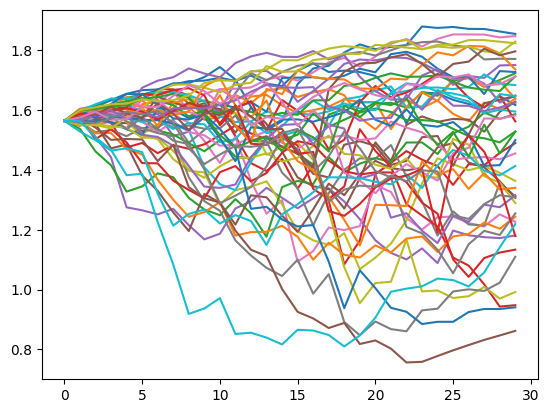

In [33]:
strats = np.random.choice(test_size, 50)
for i in strats:
    plt.plot(strategies[:,i].detach().cpu().numpy())
plt.show()

In [34]:
print(y_pred.mean())
print(y_pred.std())
print(y_pred.max())

tensor(1.1126)
tensor(0.3060)
tensor(2.7720)


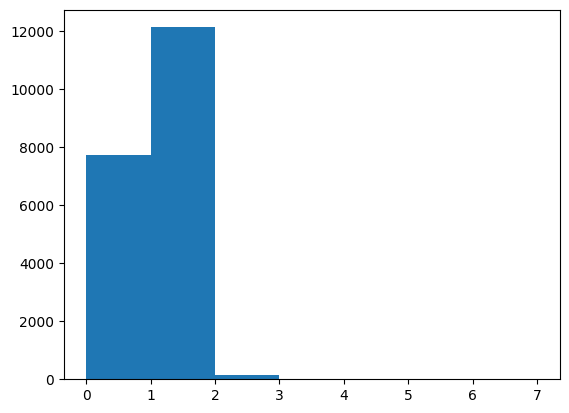

In [35]:
bins = np.arange(0, 8, 1)
plt.hist(y_pred.detach().cpu().numpy(), bins=bins)
plt.show()

In [36]:
strats = np.random.choice(test_size, 100)

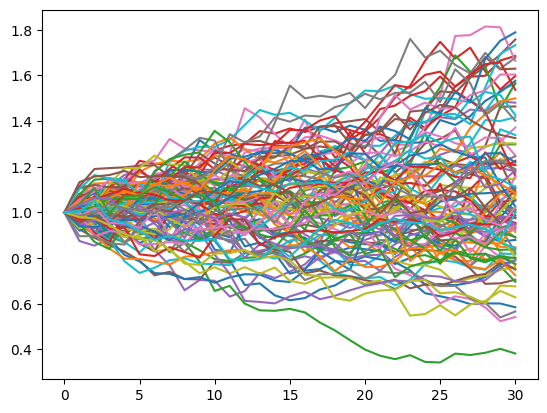

In [37]:
for i in strats:
    plt.plot(wealthpaths[:,i].detach().cpu().numpy())
plt.show()

In [38]:
if gamma == 0.0:
    utilitypaths = torch.log(wealthpaths)
else:
    utilitypaths = (wealthpaths**(gamma)-1)/gamma

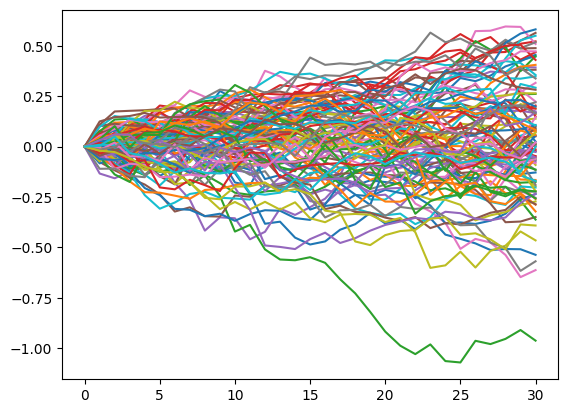

In [39]:
for i in strats:
    plt.plot(utilitypaths[:,i].detach().cpu().numpy())
plt.show()

# Path dependent Approach

### Network

In [40]:
def padding(seq, target_length):
    length = seq.size(1)
    if length < target_length:
        padding = torch.zeros(seq.size(0), target_length - length, seq.size(2), dtype=seq.dtype, device=seq.device)
        return torch.cat([padding, seq], dim=1)
    else:
        return seq[:, -target_length:, :]


In [41]:
class LSTMBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMBlock, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])

        return out
    
class IntelligentTrader(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, model_params):
        super(IntelligentTrader, self).__init__()

        self.series_length = 10

        self.model_params = model_params

        self.block = LSTMBlock(input_dim, hidden_dim, layer_dim, output_dim)

    def forward(self, x):
        r = self.model_params['r']
        
        N = self.model_params['N']
        R = self.model_params['R']
        T = self.model_params['T']
        sigma = self.model_params['sigma']
        m = self.model_params['m']

        wealth = x[:, 0, N+1]

        wealthpath = []
        strategies = []
        wealthpath.append(wealth)

        for j in range(N):
            wealthpath_tensor = torch.stack(wealthpath,dim=0)
            wealthpath_tensor = wealthpath_tensor.transpose(0,1)
            pricepaths = x[:, 0, 0:j+1]

            input = torch.cat([pricepaths.unsqueeze(-1), wealthpath_tensor.unsqueeze(-1)], dim=-1)

            input = padding(input, self.series_length)

            strategy = self.block(input)
            strategy = strategy.squeeze(1)
            strategies.append(strategy)

            logreturns = torch.log(x[:, 0, j+1]) - torch.log(x[:, 0, j])

            logwealth = torch.log(wealth) + strategy*logreturns + (1-strategy)*r*(T/N) - strategy**2*sigma**2*T/(2*N)

            newwealth = torch.exp(logwealth)

            wealth = newwealth
            wealthpath.append(wealth)
        
        outputs = wealth
        strategies = torch.stack(strategies, dim=0) 
        wealthpath = torch.stack(wealthpath, dim=0)

        return outputs, wealthpath, strategies

In [42]:
price_tensor = torch.from_numpy(heston_price_paths).float()
wealth = np.ones(shape=(m, 1, R))
wealth_tensor = torch.from_numpy(wealth).float()
trade = np.zeros(shape=(1, 1, R))
trade_tensor = torch.from_numpy(trade).float()
tradeeval = np.ones(shape=(m, 1, R))
tradeeval_tensor = torch.from_numpy(tradeeval).float()

In [43]:
price_tensor = price_tensor.permute(-1, *range(price_tensor.ndim - 1))  # Moves last dim to front
wealth_tensor = wealth_tensor.permute(-1, *range(wealth_tensor.ndim - 1))
trade_tensor = trade_tensor.permute(-1, *range(trade_tensor.ndim - 1))

In [44]:
x_train = torch.cat([price_tensor, wealth_tensor, trade_tensor], dim=2)
y_train = torch.zeros(x_train.shape[0])

dataset = TensorDataset(x_train, y_train)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [45]:
input_dim = m+1
hidden_dim = 50
layer_dim = 1
output_dim = m
d = 3
depth = N

model_params = {
    'r': r,
    'N': N,
    'R': R,
    'T': T,
    'sigma': sigma,
    'm': m
}

model = IntelligentTrader(input_dim, hidden_dim, layer_dim, output_dim, model_params)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [46]:
def custom_loss(y_true, y_pred, gamma):
    # y_pred[:, 0] selects the first column
    if gamma == 0.0:
        util = torch.log(y_pred)
    else:
        util = (y_pred ** (gamma)-1) / gamma
    loss = -torch.mean(util)
    return loss

In [47]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        x_batch, y_batch = batch

        optimizer.zero_grad()

        y_pred, wealthpaths, strats = model(x_batch)

        loss = custom_loss(y_batch, y_pred, gamma=gamma)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: -0.0538
Epoch 2/5, Loss: -0.0666
Epoch 3/5, Loss: -0.0666
Epoch 4/5, Loss: -0.0668
Epoch 5/5, Loss: -0.0668


### Evaluation

In [48]:
model.eval()
y_pred = []
wealthpaths = []
strategies = []

with torch.no_grad():
    for batch_x, _ in test_loader:
        y_pred_batch, wealthpaths_batch, strategies_batch = model(batch_x)
        y_pred.append(y_pred_batch)
        wealthpaths.append(wealthpaths_batch)
        strategies.append(strategies_batch)

y_pred = torch.cat(y_pred, dim=0)
wealthpaths = torch.cat(wealthpaths, dim=1)
strategies = torch.cat(strategies, dim=1)

In [49]:
print(y_pred.mean())
print(y_pred.std())
print(y_pred.max())

tensor(1.1221)
tensor(0.3110)
tensor(2.7064)


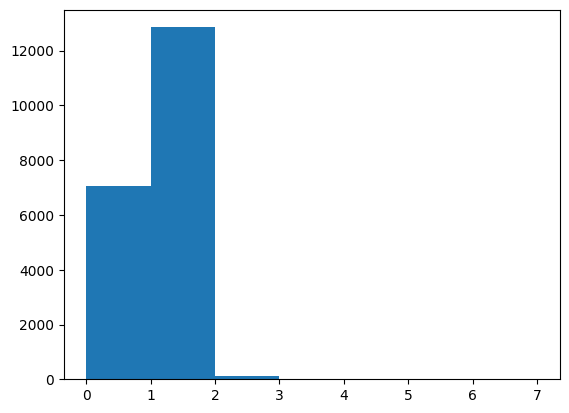

In [50]:
bins = np.arange(0, 8, 1)
plt.hist(y_pred.detach().cpu().numpy(), bins=bins)
plt.show()

In [51]:
strats = np.random.choice(test_size, 100)

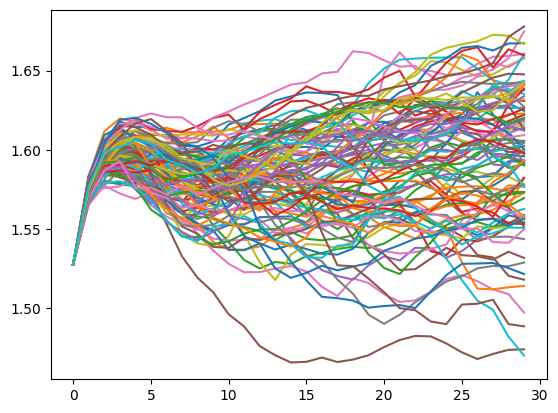

In [52]:
for i in strats:
    plt.plot(strategies[:,i].detach().cpu().numpy())
plt.show()